In [1]:
import pandas as pd
import re
import os
import glob
import snapatac2 as snap

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils
import subprocess

In [3]:
df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)

In [4]:
df_deg_select = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M") & (df_deg.region.isin(['AMY','HIP','PFC']))]

In [5]:
df_deg_select['condition'] = 'MW'
df_deg_select.loc[df_deg_select.de_coef>0,'condition'] = 'MC'

/tmp/ipykernel_3704978/3437822688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deg_select['condition'] = 'MW'


In [9]:
df_wil = pd.read_csv('/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv')
df_mementob_old = pd.read_csv('/data2st1/junyi/output/atac0416/cCRE/df_deg_mento_annotated.csv')

In [13]:
df_memento_cov = pd.read_csv('/data2st1/junyi/output/atac0416/dar/region_nt/mementoht_dar_annotated.csv')
df_memento_cov = df_memento_cov[df_memento_cov.de_pval<0.05]

In [14]:
df_memento_cr = pd.read_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_annotated.csv')
df_memento_cr = df_memento_cr[df_memento_cr.de_pval<0.05]
df_memento_dbatch = pd.read_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementoht_dar_annotated.csv')
df_memento_dbatch = df_memento_dbatch[df_memento_dbatch.de_pval<0.05]

In [37]:
df_wil.rename(columns={'gene_name': 'gene'}, inplace=True)
d_degdar_wil = df_wil.merge(df_deg_select,how='inner',left_on=['ctname','condition','gene'],right_on=['ctname','condition','gene'],suffixes=('_atac', '_sc'))
d_degdar_wil.sort_values(by='condition', ascending=False, inplace=True)
d_degdar_wil.loc[d_degdar_wil.condition=='MW','logfoldchanges'] = d_degdar_wil.loc[d_degdar_wil.condition=='MW','logfoldchanges']*-1
for ctname in d_degdar_wil.ctname.unique():
    df_ct = d_degdar_wil[d_degdar_wil.ctname == ctname]
    corr = df_ct[['logfoldchanges', 'de_coef']].corr().iloc[0, 1]
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct)}')

Correlation for PFC_Glut: 0.04,size=6834
Correlation for PFC_GABA: 0.45,size=72
Correlation for AMY_Glut: 0.52,size=143
Correlation for HIP_Glut: -0.06,size=1466
Correlation for AMY_GABA: 0.03,size=185
Correlation for HIP_GABA: nan,size=1


In [46]:
d_degdar_wil[['logfoldchanges','de_coef']].corr()

,logfoldchanges,de_coef
logfoldchanges,1.000000,0.636427
de_coef,0.636427,1.000000


In [29]:
df_memento_cov.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_cov = df_memento_cov.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_cov.ctname.unique():
    df_ct = df_degmemento_cov[df_degmemento_cov.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_cov[df_memento_cov.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.02,size=3624, IoU=0.23
Correlation for PFC_GABA: 0.02,size=1471, IoU=0.13
Correlation for HIP_Glut: 0.54,size=1606, IoU=0.12
Correlation for HIP_GABA: 0.01,size=966, IoU=0.10
Correlation for AMY_GABA: 0.48,size=974, IoU=0.09
Correlation for AMY_Glut: 0.79,size=1207, IoU=0.09


In [41]:
df_degmemento_cov[['de_coef_atac','de_coef_sc']].corr()

,de_coef_atac,de_coef_sc
de_coef_atac,1.000000,0.317278
de_coef_sc,0.317278,1.000000


In [38]:
df_memento_cr.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_cr = df_memento_cr.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_cr.ctname.unique():
    df_ct = df_degmemento_cr[df_degmemento_cr.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_cr[df_memento_cr.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')
df_memento_dbatch.rename(columns={'gene_name': 'gene'}, inplace=True)

Correlation for PFC_Glut: 0.27,size=1285, IoU=0.07
Correlation for PFC_GABA: 0.72,size=407, IoU=0.03
Correlation for HIP_GABA: 0.03,size=907, IoU=0.09
Correlation for HIP_Glut: 0.71,size=1924, IoU=0.13
Correlation for AMY_Glut: 0.74,size=2085, IoU=0.14
Correlation for AMY_GABA: 0.27,size=2087, IoU=0.18


In [40]:
df_degmemento_cr[['de_coef_atac','de_coef_sc']].corr()

,de_coef_atac,de_coef_sc
de_coef_atac,1.000000,0.775564
de_coef_sc,0.775564,1.000000


In [23]:
df_memento_dbatch.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_dbatch = df_memento_dbatch.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_dbatch.ctname.unique():
    df_ct = df_degmemento_dbatch[df_degmemento_dbatch.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_dbatch[df_memento_dbatch.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.26,size=1189, IoU=0.07
Correlation for PFC_GABA: 0.68,size=358, IoU=0.03
Correlation for HIP_Glut: 0.72,size=1944, IoU=0.13
Correlation for HIP_GABA: 0.02,size=902, IoU=0.09
Correlation for AMY_GABA: 0.25,size=2067, IoU=0.18
Correlation for AMY_Glut: 0.74,size=2101, IoU=0.14


In [35]:
df_mementob_old.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmementob_old = df_mementob_old.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmementob_old.ctname.unique():
    df_ct = df_degmementob_old[df_degmementob_old.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_mementob_old[df_mementob_old.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.26,size=1267, IoU=0.07
Correlation for PFC_GABA: 0.69,size=404, IoU=0.03
Correlation for HIP_GABA: 0.01,size=941, IoU=0.09
Correlation for HIP_Glut: 0.71,size=1904, IoU=0.13
Correlation for AMY_Glut: 0.74,size=2108, IoU=0.15
Correlation for AMY_GABA: 0.25,size=2099, IoU=0.18


<Axes: xlabel='de_coef_atac', ylabel='de_coef_sc'>

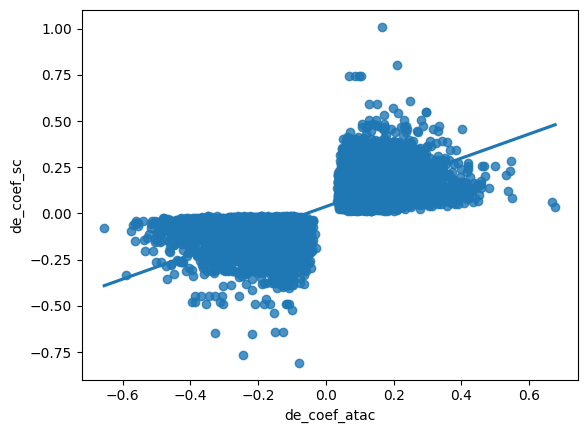

In [36]:
sns.regplot(data=df_degmementob_old, x='de_coef_atac', y='de_coef_sc')